## Preprocessing Of Regression problem

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import torch
from sklearn.model_selection import train_test_split

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


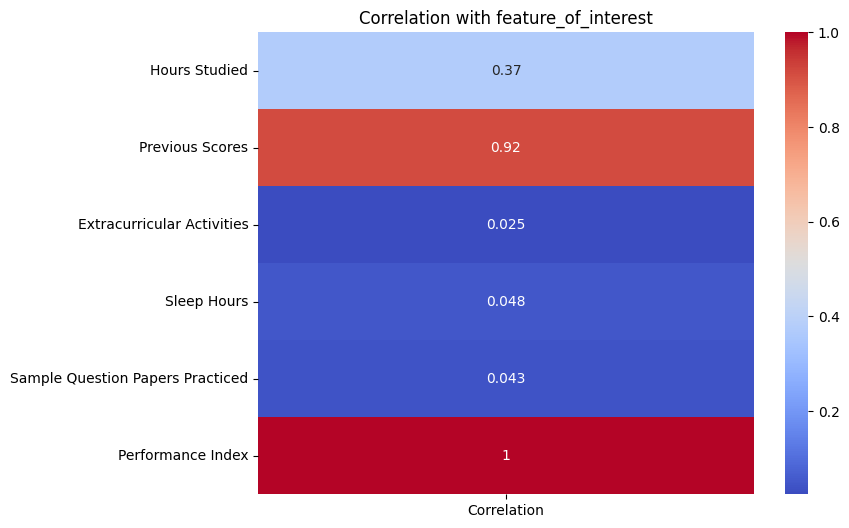

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/Student_Performance.csv'))
df.info()

features = list(df.columns[:-1])
target = df.columns[-1]

le = LabelEncoder()
for i in features:
  df[i] = le.fit_transform(df[i])

correlation_with_feature = df.corrwith(df[target])

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(correlation_with_feature, columns=['Correlation']), annot=True, cmap='coolwarm')
plt.title('Correlation with {}'.format('feature_of_interest'))
plt.show()

## Neural Network From Scratch

In [ ]:
class Dataset:
  def __init__(self, data):
    self.data = data
    self.x_train = None
    self.x_test = None
    self.y_train = None
    self.y_test = None
    self.features = []

  def display(self):
    df = pd.read_csv(self.data)
    print(df.head())

  def preprocessing(self):
    df = pd.read_csv(self.data)
    categorical_features = df.select_dtypes(include=['object']).columns
    le = LabelEncoder()

    for feature in categorical_features:
        df[feature] = le.fit_transform(df[feature])
    x = df.iloc[:,:-1].values
    y = df.iloc[:,-1].values

    if x.ndim ==1:
      x = x.reshape(-1,1)

    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    x_tensor = torch.FloatTensor(x)
    y_tensor = torch.FloatTensor(y).view(-1,1)

    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x_tensor, y_tensor, test_size=0.2, random_state=42)


In [ ]:
df = Dataset('/content/drive/MyDrive/Student_Performance.csv')
df.display()
df.preprocessing()

   Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0              7               99                        Yes            9   
1              4               82                         No            4   
2              8               51                        Yes            7   
3              5               52                        Yes            5   
4              7               75                         No            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  


### Combination 1

In [ ]:
class model:
  def __init__(self, input_dims, hidden_dims1, hidden_dims2 ,output_dims):
    self.w = torch.randn(input_dims, hidden_dims1, requires_grad=True)
    self.b = torch.randn(hidden_dims1, requires_grad=True)

    self.w2 = torch.randn(hidden_dims1, hidden_dims2, requires_grad=True)
    self.b2 = torch.randn(hidden_dims2, requires_grad=True)

    self.w3 = torch.randn(hidden_dims2, output_dims, requires_grad=True)
    self.b3 = torch.randn(output_dims, requires_grad=True)

  def mse(self, t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()

  def forward(self, x):
    x = x @ self.w + self.b
    x = torch.tanh(x)
    x = x @ self.w2 + self.b2
    x = torch.tanh(x)
    x = x @ self.w3 + self.b3
    return x

  def backward(self, predictions, y):
    loss = self.mse(predictions, y)
    loss.backward()

    with torch.no_grad():
      self.w -= self.w.grad * 1e-4
      self.b -= self.b.grad * 1e-4

      self.w2 -= self.w2.grad * 1e-4
      self.b2 -= self.b2.grad * 1e-4

      self.w3 -= self.w3.grad * 1e-4
      self.b3 -= self.b3.grad * 1e-4

    return loss.item()

  def train(self, x, y, x_val, y_val, epochs = 1000):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
      predictions = self.forward(x)
      loss = self.backward(predictions, y)
      train_losses.append(loss)

      with torch.no_grad():
        val_predictions = self.forward(x_val)
        val_loss = self.backward(val_predictions, y_val)
        val_losses.append(val_loss)

      if epoch % 100 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {loss}, Val Loss: {val_loss}")

In [ ]:
input_dims = df.x_train.shape[1]
hidden_dims1 = 20
hidden_dims2 = 10
output_dims = 1

process = model(input_dims, hidden_dims1, hidden_dims2 ,output_dims)

In [ ]:
process.train(df.x_train, df.y_train)

Epoch 1, Loss: 3300.9189453125
Epoch 101, Loss: 290.9079895019531
Epoch 201, Loss: 168.52560424804688
Epoch 301, Loss: 139.7825469970703
Epoch 401, Loss: 114.5484390258789
Epoch 501, Loss: 94.5361328125
Epoch 601, Loss: 89.08614349365234
Epoch 701, Loss: 69.5423812866211
Epoch 801, Loss: 85.55396270751953
Epoch 901, Loss: 100.37996673583984


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
with torch.no_grad():
  predictions = process.forward(df.x_test)
  r2 = r2_score(df.y_test.numpy(), predictions.numpy())
  mae = mean_absolute_error(df.y_test.numpy(), predictions.numpy())
  print(r2)
  print(mae)

0.8025281923115414
6.5634685


In [ ]:
with torch.no_grad():
  predictions = process.forward(df.x_train)
  r2 = r2_score(df.y_train.numpy(), predictions.numpy())
  mae = mean_absolute_error(df.y_train.numpy(), predictions.numpy())
  print(r2)
  print(mae)

0.8036102326294778
6.5653462


### Combination 2

In [ ]:
class model:
  def __init__(self, input_dims, hidden_dims1, hidden_dims2, hidden_dims3 ,output_dims):
    self.w = torch.randn(input_dims, hidden_dims1, requires_grad=True)
    self.b = torch.randn(hidden_dims1, requires_grad=True)

    self.w2 = torch.randn(hidden_dims1, hidden_dims2, requires_grad=True)
    self.b2 = torch.randn(hidden_dims2, requires_grad=True)

    self.w3 = torch.randn(hidden_dims2, hidden_dims3, requires_grad=True)
    self.b3 = torch.randn(hidden_dims3, requires_grad=True)

    self.w4 = torch.randn(hidden_dims3, output_dims, requires_grad=True)
    self.b4 = torch.randn(output_dims, requires_grad=True)

  def mse(self, t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()

  def forward(self, x):
    x = x @ self.w + self.b
    x = torch.tanh(x)
    x = x @ self.w2 + self.b2
    x = torch.tanh(x)
    x = x @ self.w3 + self.b3
    x = torch.tanh(x)
    x = x @ self.w4 + self.b4
    return x


  def backward(self, predictions, y):
    loss = self.mse(predictions, y)
    loss.backward()

    with torch.no_grad():
      self.w -= self.w.grad * 1e-5
      self.b -= self.b.grad * 1e-5

      self.w2 -= self.w2.grad * 1e-5
      self.b2 -= self.b2.grad * 1e-5

      self.w3 -= self.w3.grad * 1e-5
      self.b3 -= self.b3.grad * 1e-5

      self.w4 -= self.w4.grad * 1e-5
      self.b4 -= self.b4.grad * 1e-5

    return loss.item()

  def train(self, x, y, epochs = 2000):
    for epoch in range(epochs):
      predictions = self.forward(x)
      loss = self.backward(predictions, y)
      if epoch % 200 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss}")

In [ ]:
input_dims = df.x_train.shape[1]
hidden_dims1 = 40
hidden_dims2 = 15
hidden_dims3 = 10
output_dims = 1

process = model(input_dims, hidden_dims1, hidden_dims2, hidden_dims3 ,output_dims)

In [ ]:
process.train(df.x_train, df.y_train)

Epoch 1, Loss: 3196.8828125
Epoch 201, Loss: 343.9078369140625
Epoch 401, Loss: 34.39695739746094
Epoch 601, Loss: 34.705169677734375
Epoch 801, Loss: 59.596412658691406
Epoch 1001, Loss: 49.186710357666016
Epoch 1201, Loss: 34.1969108581543
Epoch 1401, Loss: 38.78520202636719
Epoch 1601, Loss: 33.43628692626953
Epoch 1801, Loss: 23.368263244628906


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
with torch.no_grad():
  predictions = process.forward(df.x_test)

  r2 = r2_score(df.y_test.numpy(), predictions.numpy())
  mae = mean_absolute_error(df.y_test.numpy(), predictions.numpy())
  print(r2)
  print(mae)

0.9308233373565461
3.9742756


In [ ]:
with torch.no_grad():
  predictions = process.forward(df.x_train)
  r2 = r2_score(df.y_train.numpy(), predictions.numpy())
  mae = mean_absolute_error(df.y_train.numpy(), predictions.numpy())
  print(r2)
  print(mae)

0.9337356666491188
3.910659


### Combination 3

In [ ]:
class model:
  def __init__(self, input_dims, hidden_dims1, hidden_dims2 ,output_dims):
    self.w = torch.randn(input_dims, hidden_dims1, requires_grad=True)
    self.b = torch.randn(hidden_dims1, requires_grad=True)

    self.w2 = torch.randn(hidden_dims1, hidden_dims2, requires_grad=True)
    self.b2 = torch.randn(hidden_dims2, requires_grad=True)

    self.w3 = torch.randn(hidden_dims2, output_dims, requires_grad=True)
    self.b3 = torch.randn(output_dims, requires_grad=True)

  def mse(self, t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()

  def forward(self, x):
    x = x @ self.w + self.b
    x = torch.tanh(x)
    x = x @ self.w2 + self.b2
    x = torch.tanh(x)
    x = x @ self.w3 + self.b3
    return x


  def backward(self, predictions, y):
    loss = self.mse(predictions, y)
    loss.backward()

    with torch.no_grad():
      self.w -= self.w.grad * 1e-3
      self.b -= self.b.grad * 1e-3

      self.w2 -= self.w2.grad * 1e-3
      self.b2 -= self.b2.grad * 1e-3

      self.w3 -= self.w3.grad * 1e-3
      self.b3 -= self.b3.grad * 1e-3

    return loss.item()

  def train(self, x, y, epochs = 2000):
    for epoch in range(epochs):
      predictions = self.forward(x)
      loss = self.backward(predictions, y)
      if epoch % 200 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss}")

In [ ]:
input_dims = df.x_train.shape[1]
hidden_dims1 = 35
hidden_dims2 = 15
output_dims = 1

process = model(input_dims, hidden_dims1, hidden_dims2 ,output_dims)

In [ ]:
process.train(df.x_train, df.y_train)

Epoch 1, Loss: 3389.43017578125
Epoch 201, Loss: 48.94154357910156
Epoch 401, Loss: 59.055721282958984
Epoch 601, Loss: 178.5327911376953
Epoch 801, Loss: 61.61423873901367
Epoch 1001, Loss: 68.47782135009766
Epoch 1201, Loss: 48.43939971923828
Epoch 1401, Loss: 36.733497619628906
Epoch 1601, Loss: 33.15536880493164
Epoch 1801, Loss: 30.913782119750977


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
with torch.no_grad():
  predictions = process.forward(df.x_test)

  r2 = r2_score(df.y_test.numpy(), predictions.numpy())
  mae = mean_absolute_error(df.y_test.numpy(), predictions.numpy())
  print(r2)
  print(mae)

0.8537029297580927
5.946709


In [ ]:
with torch.no_grad():
  predictions = process.forward(df.x_train)
  r2 = r2_score(df.y_train.numpy(), predictions.numpy())
  mae = mean_absolute_error(df.y_train.numpy(), predictions.numpy())
  print(r2)
  print(mae)

0.8542015437422282
5.9231815


### Combination 4

In [ ]:
class model:
  def __init__(self, input_dims, hidden_dims1, hidden_dims2, hidden_dims3, hidden_dims4 ,output_dims):
    self.w = torch.randn(input_dims, hidden_dims1, requires_grad=True)
    self.b = torch.randn(hidden_dims1, requires_grad=True)

    self.w2 = torch.randn(hidden_dims1, hidden_dims2, requires_grad=True)
    self.b2 = torch.randn(hidden_dims2, requires_grad=True)

    self.w3 = torch.randn(hidden_dims2, hidden_dims3, requires_grad=True)
    self.b3 = torch.randn(hidden_dims3, requires_grad=True)

    self.w4 = torch.randn(hidden_dims3, hidden_dims4, requires_grad=True)
    self.b4 = torch.randn(hidden_dims4, requires_grad=True)

    self.w5 = torch.randn(hidden_dims4, output_dims, requires_grad=True)
    self.b5 = torch.randn(output_dims, requires_grad=True)

  def mse(self, t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()

  def forward(self, x):
    x = x @ self.w + self.b
    x = torch.tanh(x)
    x = x @ self.w2 + self.b2
    x = torch.tanh(x)
    x = x @ self.w3 + self.b3
    x = torch.tanh(x)
    x = x @ self.w4 + self.b4
    x = torch.tanh(x)
    x = x @ self.w5 + self.b5
    return x


  def backward(self, predictions, y):
    loss = self.mse(predictions, y)
    loss.backward()

    with torch.no_grad():
      self.w -= self.w.grad * 1e-4
      self.b -= self.b.grad * 1e-4

      self.w2 -= self.w2.grad * 1e-4
      self.b2 -= self.b2.grad * 1e-4

      self.w3 -= self.w3.grad * 1e-4
      self.b3 -= self.b3.grad * 1e-4

      self.w4 -= self.w4.grad * 1e-4
      self.b4 -= self.b4.grad * 1e-4

      self.w5 -= self.w5.grad * 1e-4
      self.b5 -= self.b5.grad * 1e-4
    return loss.item()

  def train(self, x, y, epochs = 1000):
    for epoch in range(epochs):
      predictions = self.forward(x)
      loss = self.backward(predictions, y)
      if epoch % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss}")

In [ ]:
input_dims = df.x_train.shape[1]
hidden_dims1 = 50
hidden_dims2 = 40
hidden_dims3 = 30
hidden_dims4 = 10
output_dims = 1

process = model(input_dims, hidden_dims1, hidden_dims2, hidden_dims3, hidden_dims4 ,output_dims)

In [ ]:
process.train(df.x_train, df.y_train)

Epoch 1, Loss: 3127.278076171875
Epoch 101, Loss: 349.7157897949219
Epoch 201, Loss: 171.85537719726562
Epoch 301, Loss: 106.65399932861328
Epoch 401, Loss: 83.64785766601562
Epoch 501, Loss: 43.4434700012207
Epoch 601, Loss: 53.980289459228516
Epoch 701, Loss: 88.90687561035156
Epoch 801, Loss: 103.0412368774414
Epoch 901, Loss: 105.17381286621094


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
with torch.no_grad():
  predictions = process.forward(df.x_test)

  r2 = r2_score(df.y_test.numpy(), predictions.numpy())
  mae = mean_absolute_error(df.y_test.numpy(), predictions.numpy())
  print(r2)
  print(mae)

0.7804180649046907
7.0896378


In [ ]:
with torch.no_grad():
  predictions = process.forward(df.x_train)
  r2 = r2_score(df.y_train.numpy(), predictions.numpy())
  mae = mean_absolute_error(df.y_train.numpy(), predictions.numpy())
  print(r2)
  print(mae)

0.7868807175201834
7.006453


### Combination 5

In [ ]:
class model:
  def __init__(self, input_dims, hidden_dims1, hidden_dims2, hidden_dims3, hidden_dims4 ,output_dims):
    self.w = torch.randn(input_dims, hidden_dims1, requires_grad=True)
    self.b = torch.randn(hidden_dims1, requires_grad=True)

    self.w2 = torch.randn(hidden_dims1, hidden_dims2, requires_grad=True)
    self.b2 = torch.randn(hidden_dims2, requires_grad=True)

    self.w3 = torch.randn(hidden_dims2, hidden_dims3, requires_grad=True)
    self.b3 = torch.randn(hidden_dims3, requires_grad=True)

    self.w4 = torch.randn(hidden_dims3, hidden_dims4, requires_grad=True)
    self.b4 = torch.randn(hidden_dims4, requires_grad=True)

    self.w5 = torch.randn(hidden_dims4, output_dims, requires_grad=True)
    self.b5 = torch.randn(output_dims, requires_grad=True)

  def mse(self, t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()

  def forward(self, x):
    x = x @ self.w + self.b
    x = torch.tanh(x)
    x = x @ self.w2 + self.b2
    x = torch.tanh(x)
    x = x @ self.w3 + self.b3
    x = torch.tanh(x)
    x = x @ self.w4 + self.b4
    x = torch.tanh(x)
    x = x @ self.w5 + self.b5
    return x


  def backward(self, predictions, y):
    loss = self.mse(predictions, y)
    loss.backward()

    with torch.no_grad():
      self.w -= self.w.grad * 1e-5
      self.b -= self.b.grad * 1e-5

      self.w2 -= self.w2.grad * 1e-5
      self.b2 -= self.b2.grad * 1e-5

      self.w3 -= self.w3.grad * 1e-5
      self.b3 -= self.b3.grad * 1e-5

      self.w4 -= self.w4.grad * 1e-5
      self.b4 -= self.b4.grad * 1e-5

      self.w5 -= self.w5.grad * 1e-5
      self.b5 -= self.b5.grad * 1e-5


    return loss.item()
  def train(self, x, y, x_val, y_val, epochs = 1000):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
      predictions = self.forward(x)
      loss = self.backward(predictions, y)
      train_losses.append(loss)

      with torch.no_grad():
        val_predictions = self.forward(x_val)
        val_loss = self.mse(val_predictions, y_val).item()
        val_losses.append(val_loss)

      if epoch % 100 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {loss}, Val Loss: {val_loss}")
    return train_losses, val_losses

In [ ]:
input_dims = df.x_train.shape[1]
hidden_dims1 = 60
hidden_dims2 = 50
hidden_dims3 = 40
hidden_dims4 = 30
output_dims = 1

process = model(input_dims, hidden_dims1, hidden_dims2, hidden_dims3, hidden_dims4 ,output_dims)

In [ ]:
train_losses, val_losses = process.train(df.x_train, df.y_train, df.x_test, df.y_test)

Epoch 1, Train Loss: 3603.767578125, Val Loss: 3519.967041015625
Epoch 101, Train Loss: 336.7752380371094, Val Loss: 327.3760681152344
Epoch 201, Train Loss: 547.3468017578125, Val Loss: 525.3990478515625
Epoch 301, Train Loss: 523.6129760742188, Val Loss: 509.96112060546875
Epoch 401, Train Loss: 196.66807556152344, Val Loss: 216.76141357421875
Epoch 501, Train Loss: 115.7192153930664, Val Loss: 110.46369171142578
Epoch 601, Train Loss: 74.53287506103516, Val Loss: 74.40567779541016
Epoch 701, Train Loss: 73.19900512695312, Val Loss: 77.9764404296875
Epoch 801, Train Loss: 78.5976791381836, Val Loss: 82.37814331054688
Epoch 901, Train Loss: 78.00910186767578, Val Loss: 85.8177261352539


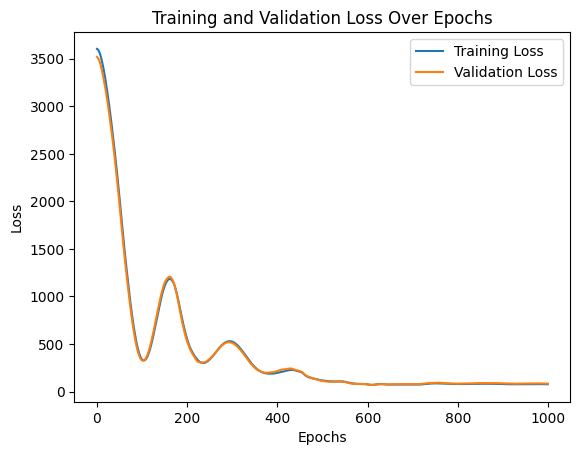

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
with torch.no_grad():
    predictions = process.forward(df.x_test)
    r2 = r2_score(df.y_test.numpy(), predictions.numpy())
    mse = mean_squared_error(df.y_test.numpy(), predictions.numpy())
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(df.y_test.numpy(), predictions.numpy())
    print(f"Test R2 Score: {r2}")
    print(f"Test MAE: {mae}")
    print(f"Test RMSE: {rmse}")
    print(f"Test MSE: {mse}")

Test R2 Score: 0.7758835387432235
Test MAE: 7.24871301651001
Test RMSE: 9.113409042358398
Test MSE: 83.05422973632812


In [ ]:
with torch.no_grad():
  predictions = process.forward(df.x_train)
  r2 = r2_score(df.y_train.numpy(), predictions.numpy())
  mae = mean_absolute_error(df.y_train.numpy(), predictions.numpy())
  mse = mean_squared_error(df.y_train.numpy(), predictions.numpy())
  rmse = np.sqrt(mse)
  print(f"Train R2 Score: {r2}")
  print(f"Train MAE: {mae}")
  print(f"Train RMSE: {rmse}")
  print(f"Train MSE: {mse}")


Train R2 Score: 0.792798963865793
Train MAE: 6.936405181884766
Train RMSE: 8.740103721618652
Train MSE: 76.38941955566406


## Neural Network Without Scratch

Epoch [100/1000], Loss: 3427.5671, Val Loss: 3381.4795
Epoch [200/1000], Loss: 3348.7073, Val Loss: 3301.7617
Epoch [300/1000], Loss: 2892.8076, Val Loss: 2844.3179
Epoch [400/1000], Loss: 1625.1456, Val Loss: 1587.8480
Epoch [500/1000], Loss: 399.1112, Val Loss: 402.3773
Epoch [600/1000], Loss: 161.0879, Val Loss: 174.7964
Epoch [700/1000], Loss: 103.8582, Val Loss: 113.4172
Epoch [800/1000], Loss: 77.3160, Val Loss: 83.9027
Epoch [900/1000], Loss: 64.2238, Val Loss: 68.9501
Epoch [1000/1000], Loss: 57.2406, Val Loss: 60.8304


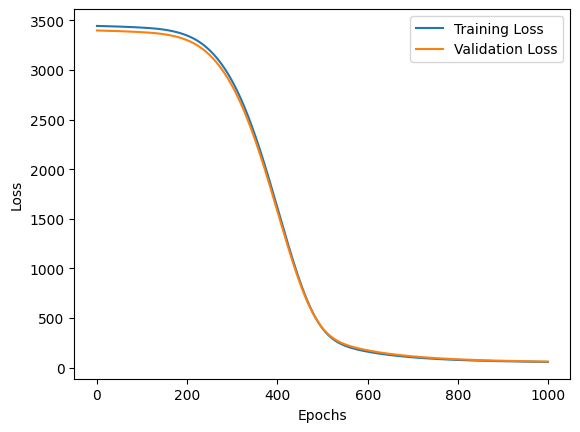

Train R2: 0.8449, Validation R2: 0.8359
Train MAE: 6.0609, Validation MAE: 6.2232


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Define the MLP model using nn.Module
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim2, hidden_dim3, hidden_dim4, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.layer4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.layer5 = nn.Linear(hidden_dim4, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.relu(x)
        x = self.layer4(x)
        x = self.relu(x)
        x = self.layer5(x)
        return x

# Hyperparameters
input_dim = 5  # Number of input features
hidden_dim = 60
hidden_dim2 = 50
hidden_dim3 = 40
hidden_dim4 = 30 # Number of neurons in each hidden layer
output_dim = 1  # Output dimension (1 for regression)
learning_rate = 0.0001
epochs = 1000

# Load and preprocess the dataset
dataset_path = '/content/drive/MyDrive/Student_Performance.csv'  # Replace with your dataset path
data = pd.read_csv(dataset_path)

# Handle categorical variables if any
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Assuming the last column is the target variable and the rest are features
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert numpy arrays to torch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().view(-1, 1)
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float().view(-1, 1)

# Initialize the model, loss function, and optimizer
model = MLP(input_dim, hidden_dim, hidden_dim2, hidden_dim3, hidden_dim4, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    # Store losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Print the loss for every 10th epoch
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Plotting the learning curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    train_predictions = model(X_train).numpy()
    val_predictions = model(X_val).numpy()

    train_r2 = r2_score(y_train, train_predictions)
    val_r2 = r2_score(y_val, val_predictions)

    train_mae = mean_absolute_error(y_train, train_predictions)
    val_mae = mean_absolute_error(y_val, val_predictions)

print(f'Train R2: {train_r2:.4f}, Validation R2: {val_r2:.4f}')
print(f'Train MAE: {train_mae:.4f}, Validation MAE: {val_mae:.4f}')


In [ ]:
train_r2 = model.evaluate_model(df.x_train, df.y_train)
print(f"Training R2 Score: {train_r2}")

test_r2 = model.evaluate_model(df.x_test, df.y_test)
print(f"Test R2 Score: {test_r2}")



Training R2 Score: -8.238687946540379
Test R2 Score: -8.067058090243817


In [ ]:
print(min(predictions))
print(max(predictions))

tensor([36.5055])
tensor([77.5524])


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
with torch.no_grad():
  predictions = process.forward(df.x_test)
  r2 = r2_score(df.y_test.numpy(), predictions.numpy())
  mae = mean_absolute_error(df.y_test.numpy(), predictions.numpy())
  print(r2)
  print(mae)

## CNN Image classification

In [ ]:
!pip install transforms

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16
from torchvision.models import resnet18
from torchvision.models import mobilenet_v2
from torchvision.models import densenet121
from torchvision.models import inception_v3

# Set random seed for reproducibility
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),  # VGG models expect 224x224 input images
    transforms.Grayscale(num_output_channels=3),  # Convert single-channel images to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
!unzip '/content/drive/MyDrive/cat.zip'

Archive:  /content/drive/MyDrive/cat.zip
  inflating: EfficientNetB0-10-(224 X 224)-100.00.h5  
  inflating: MobileNetV3 small-10-(224 X 224)-95.96.h5  
  inflating: WILDCATS.CSV            
  inflating: test/AFRICAN LEOPARD/1.jpg  
  inflating: test/AFRICAN LEOPARD/2.jpg  
  inflating: test/AFRICAN LEOPARD/3.jpg  
  inflating: test/AFRICAN LEOPARD/4.jpg  
  inflating: test/AFRICAN LEOPARD/5.jpg  
  inflating: test/CARACAL/1.jpg      
  inflating: test/CARACAL/2.jpg      
  inflating: test/CARACAL/3.jpg      
  inflating: test/CARACAL/4.jpg      
  inflating: test/CARACAL/5.jpg      
  inflating: test/CHEETAH/1.jpg      
  inflating: test/CHEETAH/2.jpg      
  inflating: test/CHEETAH/3.jpg      
  inflating: test/CHEETAH/4.jpg      
  inflating: test/CHEETAH/5.jpg      
  inflating: test/CLOUDED LEOPARD/1.jpg  
  inflating: test/CLOUDED LEOPARD/2.jpg  
  inflating: test/CLOUDED LEOPARD/3.jpg  
  inflating: test/CLOUDED LEOPARD/4.jpg  
  inflating: test/CLOUDED LEOPARD/5.jpg  
  inflati

In [ ]:
train_dataset = torchvision.datasets.ImageFolder('/content/train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder('/content/test', transform=transform)
val_dataset = torchvision.datasets.ImageFolder('/content/valid', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

## VGG16

### Combination 1

In [ ]:
model = vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 133MB/s]


In [ ]:
model.classifier[6] = nn.Linear(4096, 10)
model = model.to(device)

Epoch 1, Train Loss: 2.3055, Train Accuracy: 12.48%, Validation Loss: 2.8706, Validation Accuracy: 10.00%
Elapsed Time: 42.78 seconds
--------------------------------------------------

Epoch 2, Train Loss: 2.0469, Train Accuracy: 21.42%, Validation Loss: 1.9676, Validation Accuracy: 30.00%
Elapsed Time: 42.04 seconds
--------------------------------------------------

Epoch 3, Train Loss: 1.7776, Train Accuracy: 27.96%, Validation Loss: 1.9965, Validation Accuracy: 24.00%
Elapsed Time: 42.11 seconds
--------------------------------------------------

Epoch 4, Train Loss: 1.7385, Train Accuracy: 31.25%, Validation Loss: 2.4042, Validation Accuracy: 28.00%
Elapsed Time: 42.44 seconds
--------------------------------------------------

Epoch 5, Train Loss: 1.5688, Train Accuracy: 34.63%, Validation Loss: 1.6902, Validation Accuracy: 32.00%
Elapsed Time: 42.59 seconds
--------------------------------------------------

Epoch 6, Train Loss: 1.4789, Train Accuracy: 38.95%, Validation Loss: 

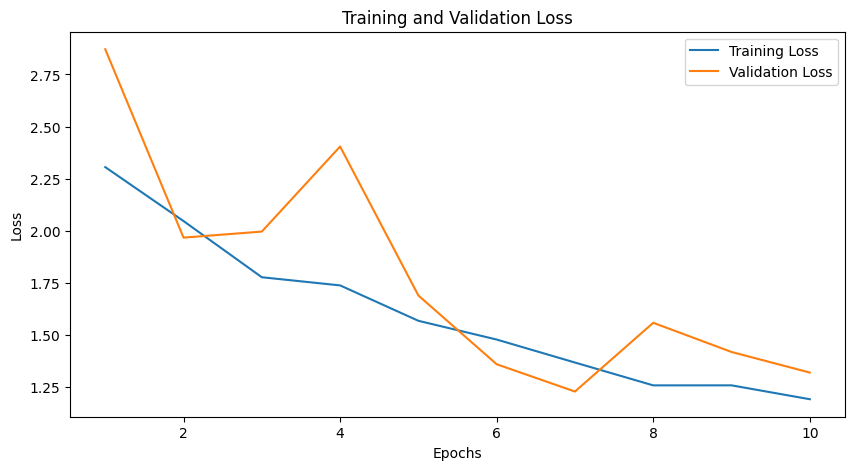

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=(0.9,0.99), lr=0.001)

import time

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Combination 2

In [ ]:
model = vgg16(pretrained=True)

model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)
model = model.to(device)

Epoch 1, Train Loss: 0.9926, Train Accuracy: 64.47%, Validation Loss: 0.1871, Validation Accuracy: 90.00%
Elapsed Time: 47.23 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.3767, Train Accuracy: 88.11%, Validation Loss: 0.2068, Validation Accuracy: 94.00%
Elapsed Time: 46.71 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.2720, Train Accuracy: 91.06%, Validation Loss: 0.2026, Validation Accuracy: 86.00%
Elapsed Time: 46.78 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.2380, Train Accuracy: 91.96%, Validation Loss: 0.0860, Validation Accuracy: 94.00%
Elapsed Time: 46.55 seconds
--------------------------------------------------

Epoch 5, Train Loss: 0.1034, Train Accuracy: 96.88%, Validation Loss: 0.0518, Validation Accuracy: 98.00%
Elapsed Time: 46.58 seconds
--------------------------------------------------



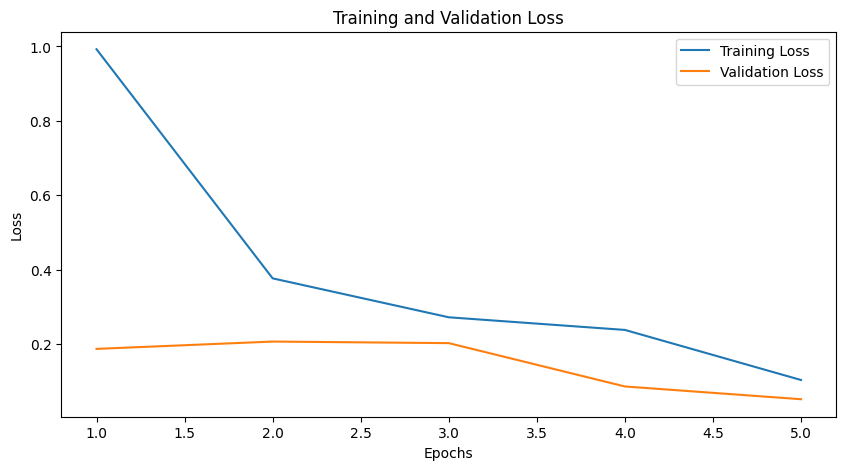

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

import time

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Combination 3

In [ ]:
model = vgg16(pretrained=True)

model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)
model = model.to(device)

Epoch 1, Train Loss: 1.9117, Train Accuracy: 32.15%, Validation Loss: 0.8689, Validation Accuracy: 72.00%
Elapsed Time: 44.02 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.8610, Train Accuracy: 70.76%, Validation Loss: 0.2981, Validation Accuracy: 92.00%
Elapsed Time: 45.73 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.5050, Train Accuracy: 82.77%, Validation Loss: 0.2471, Validation Accuracy: 92.00%
Elapsed Time: 46.37 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.3655, Train Accuracy: 88.80%, Validation Loss: 0.2004, Validation Accuracy: 90.00%
Elapsed Time: 46.98 seconds
--------------------------------------------------

Epoch 5, Train Loss: 0.2450, Train Accuracy: 92.13%, Validation Loss: 0.1454, Validation Accuracy: 94.00%
Elapsed Time: 46.67 seconds
--------------------------------------------------

Epoch 6, Train Loss: 0.1877, Train Accuracy: 94.14%, Validation Loss: 

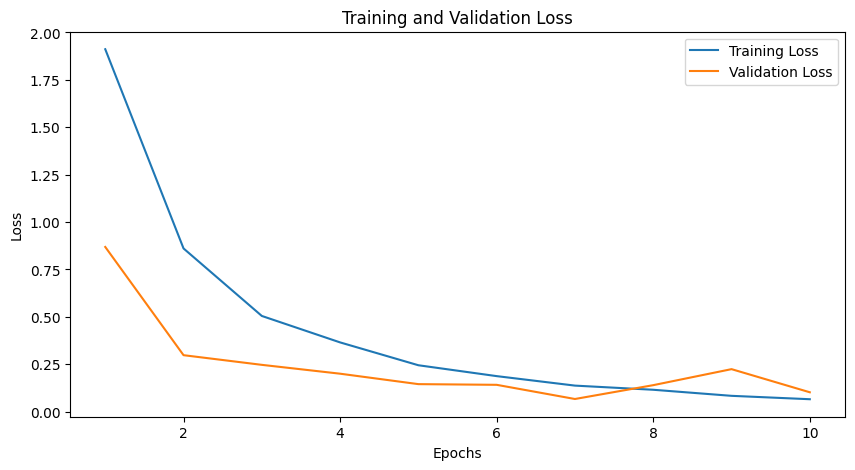

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, betas=(0.55, 0.555))

import time

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Combination 4

In [ ]:
model = vgg16(pretrained=True)

model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 2048),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.7),
    nn.Linear(512, 10)


)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 1.3187, Train Accuracy: 52.29%, Validation Loss: 0.3396, Validation Accuracy: 86.00%
Elapsed Time: 48.90 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.4505, Train Accuracy: 85.85%, Validation Loss: 0.2317, Validation Accuracy: 90.00%
Elapsed Time: 47.65 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.3081, Train Accuracy: 89.78%, Validation Loss: 0.4863, Validation Accuracy: 86.00%
Elapsed Time: 47.14 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.3986, Train Accuracy: 88.29%, Validation Loss: 0.1990, Validation Accuracy: 94.00%
Elapsed Time: 46.96 seconds
--------------------------------------------------

Epoch 5, Train Loss: 0.1882, Train Accuracy: 94.06%, Validation Loss: 0.2665, Validation Accuracy: 90.00%
Elapsed Time: 46.91 seconds
--------------------------------------------------



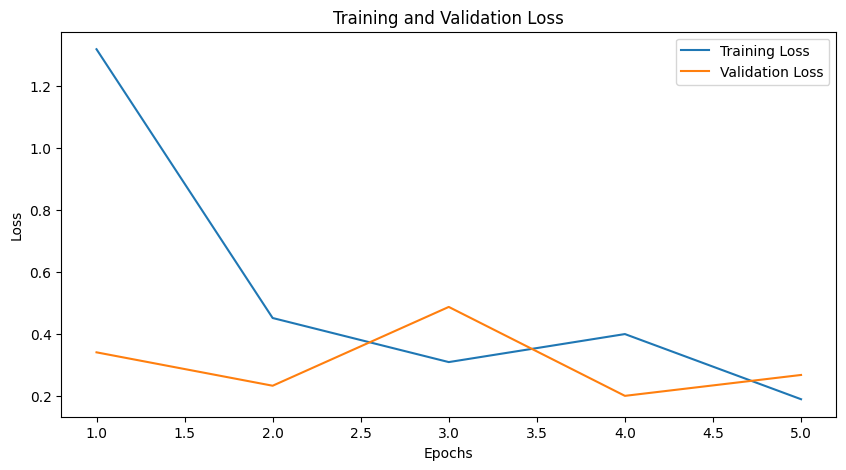

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas = (0.9, 0.999))

import time

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Resnet18

### Combination 1

In [ ]:
model = resnet18(pretrained=True)

model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)

)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


Epoch 1, Train Loss: 1.0952, Train Accuracy: 61.91%, Validation Loss: 1.5679, Validation Accuracy: 50.00%
Elapsed Time: 14.12 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.6705, Train Accuracy: 77.81%, Validation Loss: 1.6108, Validation Accuracy: 66.00%
Elapsed Time: 14.48 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.6312, Train Accuracy: 80.38%, Validation Loss: 0.5744, Validation Accuracy: 78.00%
Elapsed Time: 13.82 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.5644, Train Accuracy: 81.57%, Validation Loss: 2.3625, Validation Accuracy: 46.00%
Elapsed Time: 13.78 seconds
--------------------------------------------------

Epoch 5, Train Loss: 0.5795, Train Accuracy: 82.13%, Validation Loss: 0.5587, Validation Accuracy: 80.00%
Elapsed Time: 13.89 seconds
--------------------------------------------------

Epoch 6, Train Loss: 0.4779, Train Accuracy: 84.91%, Validation Loss: 

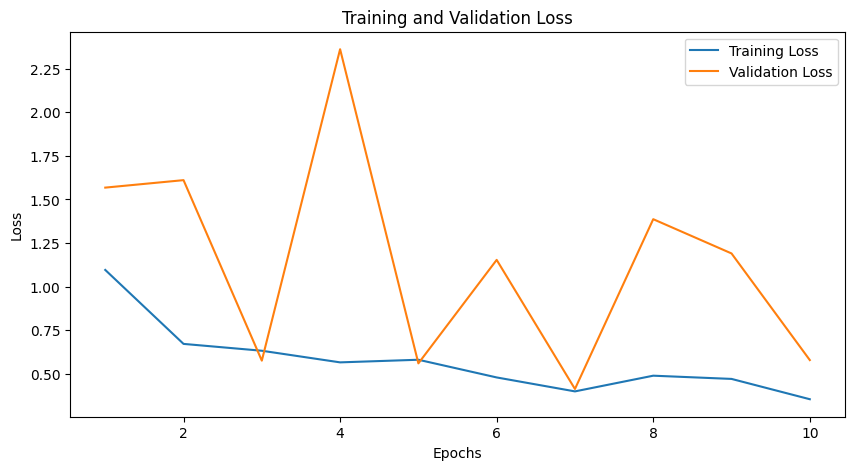

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.001)

import time

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Combination 2

In [ ]:
model = resnet18(pretrained=True)

model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)

)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]


Epoch 1, Train Loss: 1.2637, Train Accuracy: 64.13%, Validation Loss: 0.4360, Validation Accuracy: 88.00%
Elapsed Time: 18.97 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.3462, Train Accuracy: 92.09%, Validation Loss: 0.2276, Validation Accuracy: 92.00%
Elapsed Time: 12.95 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.1467, Train Accuracy: 97.26%, Validation Loss: 0.2958, Validation Accuracy: 90.00%
Elapsed Time: 12.89 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.0791, Train Accuracy: 98.59%, Validation Loss: 0.2451, Validation Accuracy: 90.00%
Elapsed Time: 13.06 seconds
--------------------------------------------------

Epoch 5, Train Loss: 0.0423, Train Accuracy: 99.49%, Validation Loss: 0.2384, Validation Accuracy: 90.00%
Elapsed Time: 13.03 seconds
--------------------------------------------------



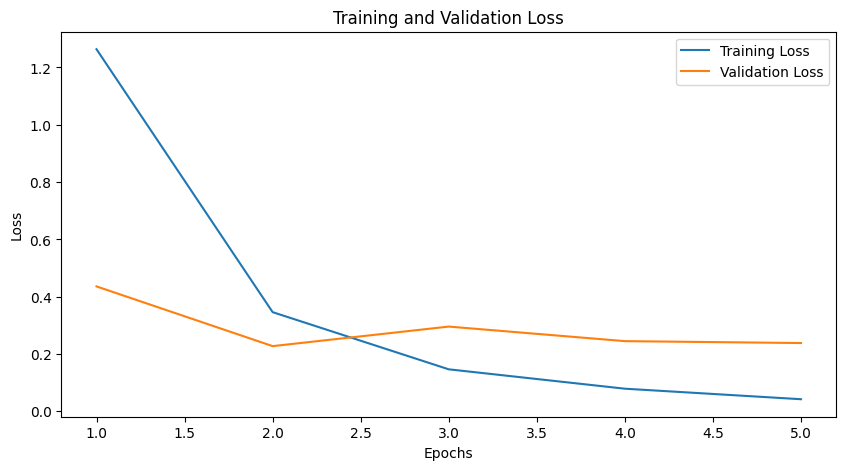

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.0001)

import time

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Combination 3

In [ ]:
model = resnet18(pretrained=True)

model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)

)
model = model.to(device)

Epoch 1, Train Loss: 2.2197, Train Accuracy: 19.97%, Validation Loss: 2.0415, Validation Accuracy: 48.00%
Elapsed Time: 14.58 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.9223, Train Accuracy: 47.33%, Validation Loss: 1.7357, Validation Accuracy: 70.00%
Elapsed Time: 13.96 seconds
--------------------------------------------------

Epoch 3, Train Loss: 1.6037, Train Accuracy: 66.05%, Validation Loss: 1.3968, Validation Accuracy: 78.00%
Elapsed Time: 13.94 seconds
--------------------------------------------------

Epoch 4, Train Loss: 1.3130, Train Accuracy: 74.69%, Validation Loss: 1.1058, Validation Accuracy: 82.00%
Elapsed Time: 13.96 seconds
--------------------------------------------------

Epoch 5, Train Loss: 1.0431, Train Accuracy: 81.23%, Validation Loss: 0.8574, Validation Accuracy: 86.00%
Elapsed Time: 14.01 seconds
--------------------------------------------------

Epoch 6, Train Loss: 0.8589, Train Accuracy: 85.29%, Validation Loss: 

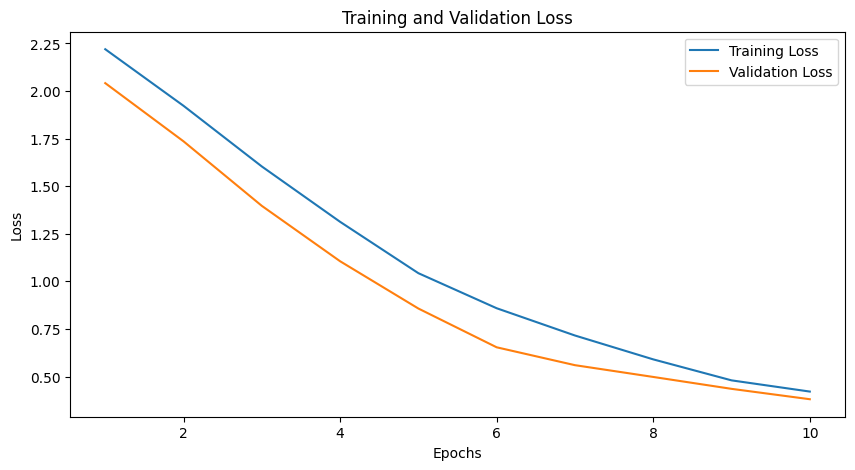

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay = 0.0005, betas=(0.9, 0.999))

import time

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Combination 4

In [ ]:
model = resnet18(pretrained=True)

model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)


)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 2.0671, Train Accuracy: 20.44%, Validation Loss: 2.0242, Validation Accuracy: 26.00%
Elapsed Time: 18.09 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.9721, Train Accuracy: 20.14%, Validation Loss: 1.9280, Validation Accuracy: 20.00%
Elapsed Time: 14.88 seconds
--------------------------------------------------

Epoch 3, Train Loss: 1.8928, Train Accuracy: 21.42%, Validation Loss: 1.9331, Validation Accuracy: 26.00%
Elapsed Time: 13.83 seconds
--------------------------------------------------

Epoch 4, Train Loss: 1.8283, Train Accuracy: 24.71%, Validation Loss: 1.7395, Validation Accuracy: 30.00%
Elapsed Time: 13.87 seconds
--------------------------------------------------

Epoch 5, Train Loss: 1.7673, Train Accuracy: 25.14%, Validation Loss: 1.7996, Validation Accuracy: 28.00%
Elapsed Time: 13.83 seconds
--------------------------------------------------



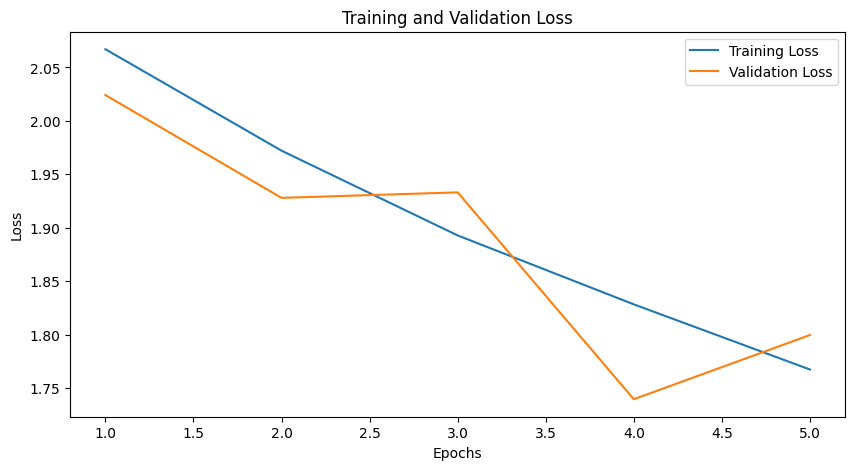

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.001, betas=(0.9, 0.999))

import time

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Mobilenet V2

### Combination 1

In [ ]:
model = mobilenet_v2(pretrained=True)

model.classifier[1] = nn.Linear(1280, 10)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 45.8MB/s]


Epoch 1, Train Loss: 0.9724, Train Accuracy: 72.60%, Validation Loss: 0.2778, Validation Accuracy: 92.00%
Elapsed Time: 15.75 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.2794, Train Accuracy: 92.26%, Validation Loss: 0.1832, Validation Accuracy: 98.00%
Elapsed Time: 16.76 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.1620, Train Accuracy: 96.28%, Validation Loss: 0.1457, Validation Accuracy: 98.00%
Elapsed Time: 15.62 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.0986, Train Accuracy: 97.95%, Validation Loss: 0.0944, Validation Accuracy: 98.00%
Elapsed Time: 15.68 seconds
--------------------------------------------------

Epoch 5, Train Loss: 0.0585, Train Accuracy: 98.67%, Validation Loss: 0.1320, Validation Accuracy: 96.00%
Elapsed Time: 15.62 seconds
--------------------------------------------------

Epoch 7, Train Loss: 0.0320, Train Accuracy: 99.70%, Validation Loss: 

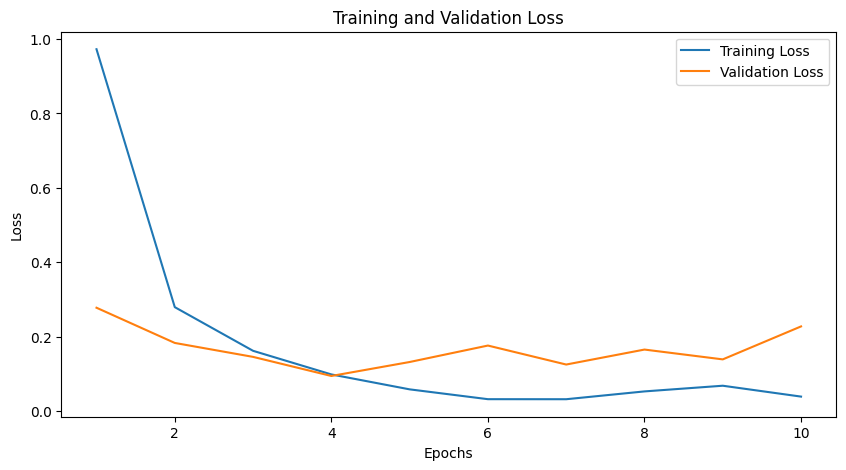

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.01)

import time

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Combination 2

In [ ]:
model = mobilenet_v2(pretrained=True)

model.classifier[1] = nn.Sequential(
    nn.Linear(1280, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 222MB/s]


Epoch 1, Train Loss: 1.3384, Train Accuracy: 61.91%, Validation Loss: 0.4133, Validation Accuracy: 80.00%
Elapsed Time: 14.98 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.4447, Train Accuracy: 87.43%, Validation Loss: 0.2556, Validation Accuracy: 92.00%
Elapsed Time: 14.88 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.2326, Train Accuracy: 93.59%, Validation Loss: 0.1760, Validation Accuracy: 96.00%
Elapsed Time: 14.88 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.1650, Train Accuracy: 95.77%, Validation Loss: 0.1307, Validation Accuracy: 94.00%
Elapsed Time: 15.01 seconds
--------------------------------------------------

Epoch 5, Train Loss: 0.1099, Train Accuracy: 97.56%, Validation Loss: 0.1034, Validation Accuracy: 96.00%
Elapsed Time: 14.92 seconds
--------------------------------------------------



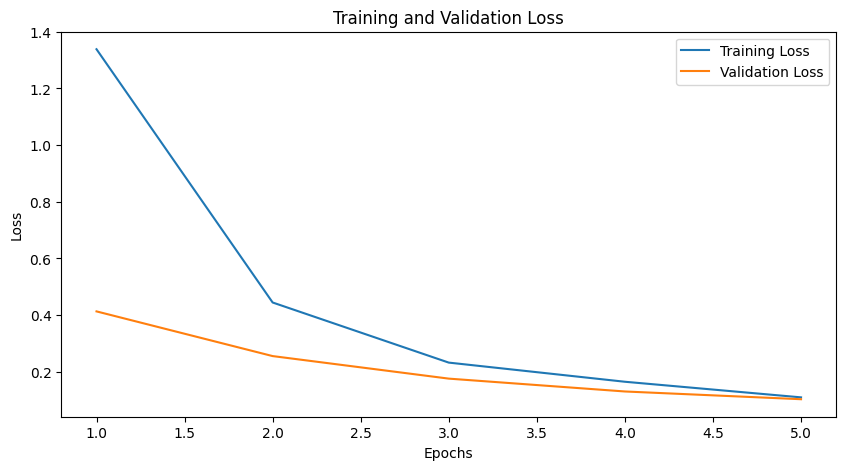

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.0001)

import time

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Combination 3

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = mobilenet_v2(pretrained=True).to(device)
model.classifier[1] = nn.Sequential(
    nn.Linear(1280, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10)
).to(device)
model.load_state_dict(torch.load('mobilenet_v2.pth', map_location=device))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Epoch 1, Train Loss: 1.4742, Train Accuracy: 47.16%, Validation Loss: 0.9198, Validation Accuracy: 62.00%
Elapsed Time: 15.06 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.9885, Train Accuracy: 65.03%, Validation Loss: 0.9661, Validation Accuracy: 68.00%
Elapsed Time: 14.92 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.8425, Train Accuracy: 71.70%, Validation Loss: 0.8718, Validation Accuracy: 72.00%
Elapsed Time: 16.45 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.6952, Train Accuracy: 78.50%, Validation Loss: 0.3279, Validation Accuracy: 88.00%
Elapsed Time: 14.86 seconds
--------------------------------------------------

Epoch 5, Train Loss: 0.7498, Train Accuracy: 75.42%, Validation Loss: 0.4192, Validation Accuracy: 80.00%
Elapsed Time: 15.01 seconds
--------------------------------------------------



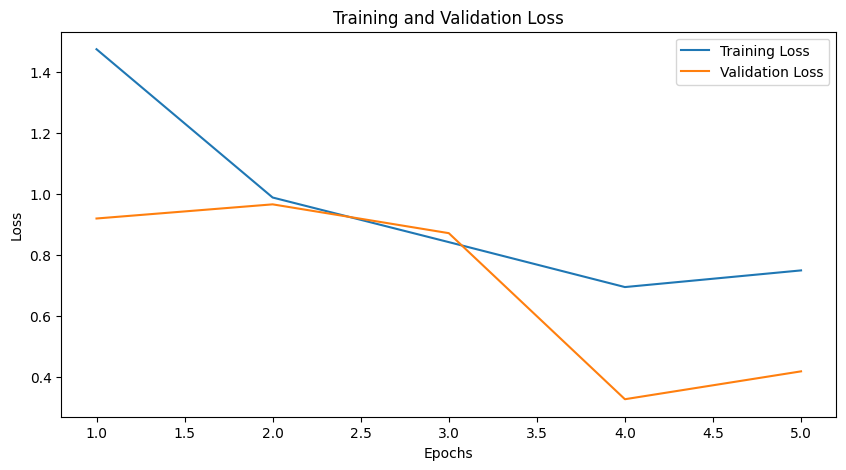

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.001)

import time

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'mobilenet_v2.pth')


### Combination 4

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
model = mobilenet_v2(pretrained=True)

model.classifier[1] = nn.Sequential(
    nn.Linear(1280, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.7),
    nn.Linear(128, 10)

)
model = model.to(device)

Epoch 1, Train Loss: 1.3625, Train Accuracy: 54.81%, Validation Loss: 1.5266, Validation Accuracy: 56.00%
Elapsed Time: 15.72 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.0640, Train Accuracy: 67.55%, Validation Loss: 0.9223, Validation Accuracy: 62.00%
Elapsed Time: 15.76 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.9523, Train Accuracy: 69.17%, Validation Loss: 0.7985, Validation Accuracy: 72.00%
Elapsed Time: 15.78 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.8649, Train Accuracy: 74.86%, Validation Loss: 0.6976, Validation Accuracy: 74.00%
Elapsed Time: 16.13 seconds
--------------------------------------------------

Epoch 5, Train Loss: 0.8036, Train Accuracy: 75.33%, Validation Loss: 0.7820, Validation Accuracy: 66.00%
Elapsed Time: 15.71 seconds
--------------------------------------------------

Epoch 6, Train Loss: 0.7839, Train Accuracy: 76.83%, Validation Loss: 

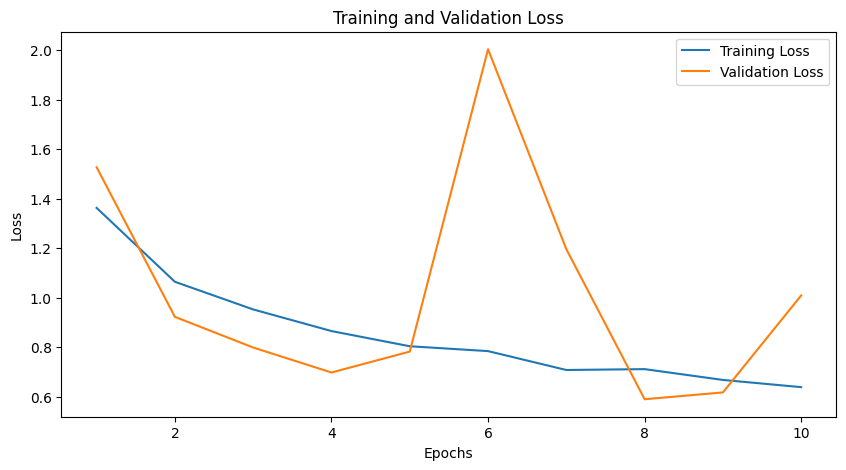

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.01, betas=(0.5, 0.5555))

import time

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Densenet121

### Combination 1

In [ ]:
model = densenet121(pretrained=True)

model.classifier = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 84.2MB/s]


Epoch 1, Train Loss: 1.0782, Train Accuracy: 61.99%, Validation Loss: 0.7477, Validation Accuracy: 78.00%
Elapsed Time: 32.28 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.6431, Train Accuracy: 78.88%, Validation Loss: 1.5120, Validation Accuracy: 42.00%
Elapsed Time: 31.82 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.6160, Train Accuracy: 80.68%, Validation Loss: 0.5004, Validation Accuracy: 82.00%
Elapsed Time: 31.72 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.6420, Train Accuracy: 78.54%, Validation Loss: 1.0309, Validation Accuracy: 66.00%
Elapsed Time: 31.58 seconds
--------------------------------------------------

Epoch 5, Train Loss: 0.4674, Train Accuracy: 83.97%, Validation Loss: 0.3650, Validation Accuracy: 88.00%
Elapsed Time: 31.72 seconds
--------------------------------------------------



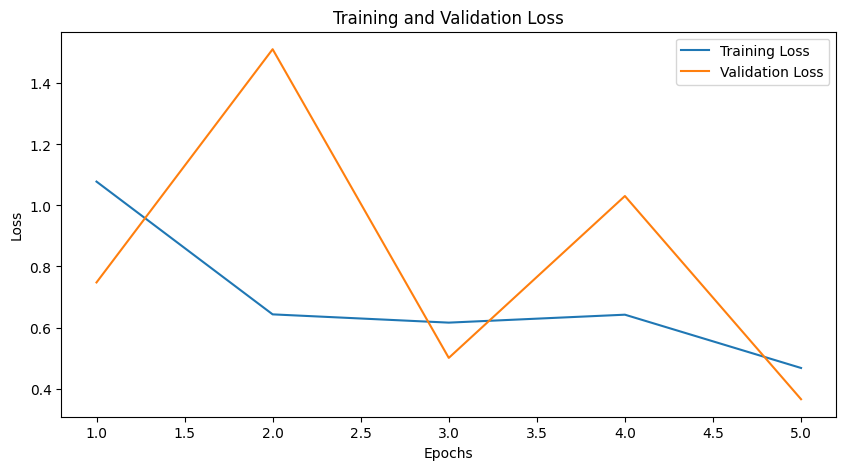

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.001)

import time

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Combination 2

In [ ]:
model = densenet121(pretrained=True)

model.classifier = nn.Sequential(
    nn.Linear(1024, 768),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)

)
model = model.to(device)

Epoch 1, Train Loss: 1.3831, Train Accuracy: 49.47%, Validation Loss: 3.1776, Validation Accuracy: 36.00%
Elapsed Time: 31.78 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.0546, Train Accuracy: 65.75%, Validation Loss: 0.9711, Validation Accuracy: 62.00%
Elapsed Time: 31.66 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.8011, Train Accuracy: 73.15%, Validation Loss: 0.6823, Validation Accuracy: 70.00%
Elapsed Time: 31.73 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.6258, Train Accuracy: 78.75%, Validation Loss: 0.5743, Validation Accuracy: 78.00%
Elapsed Time: 31.49 seconds
--------------------------------------------------

Epoch 5, Train Loss: 0.5867, Train Accuracy: 80.08%, Validation Loss: 0.8158, Validation Accuracy: 68.00%
Elapsed Time: 31.58 seconds
--------------------------------------------------



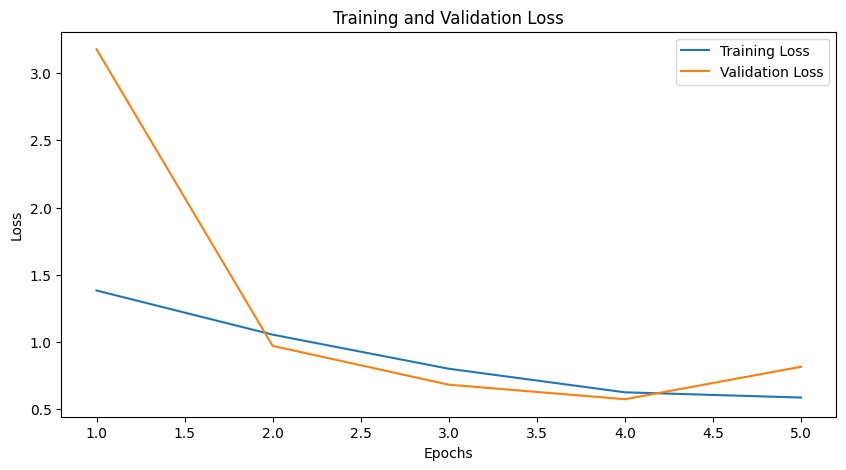

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.001)

import time

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Combination 3

In [ ]:
model = densenet121(pretrained=True)

model.classifier = nn.Sequential(
    nn.Linear(1024, 768),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.7),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 2.2313, Train Accuracy: 18.26%, Validation Loss: 1.8787, Validation Accuracy: 42.00%
Elapsed Time: 31.52 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.5342, Train Accuracy: 48.18%, Validation Loss: 0.5881, Validation Accuracy: 82.00%
Elapsed Time: 31.32 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.6409, Train Accuracy: 79.69%, Validation Loss: 0.2624, Validation Accuracy: 92.00%
Elapsed Time: 31.99 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.3534, Train Accuracy: 89.01%, Validation Loss: 0.2296, Validation Accuracy: 92.00%
Elapsed Time: 32.01 seconds
--------------------------------------------------

Epoch 5, Train Loss: 0.2271, Train Accuracy: 92.86%, Validation Loss: 0.1273, Validation Accuracy: 90.00%
Elapsed Time: 31.77 seconds
--------------------------------------------------

Epoch 6, Train Loss: 0.1370, Train Accuracy: 96.07%, Validation Loss: 

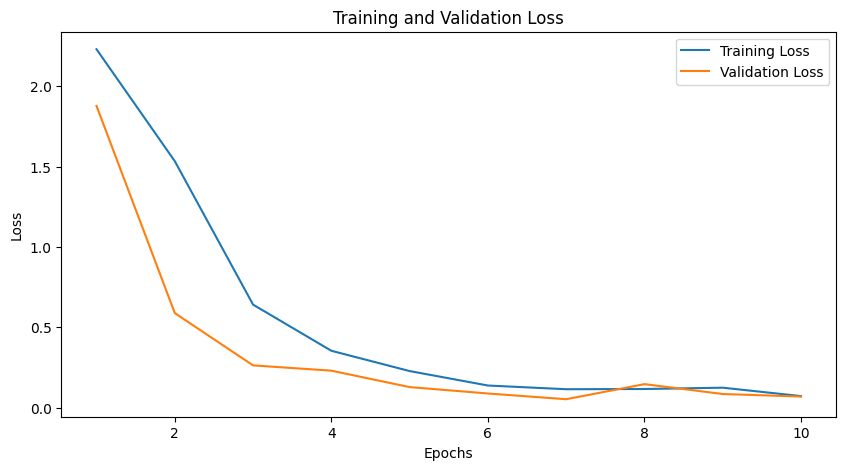

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.0001)

import time

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Combination 4

In [ ]:
model = densenet121(pretrained=True)

model.classifier = nn.Linear(1024, 10)

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 58.7MB/s]


Epoch 1, Train Loss: 2.1126, Train Accuracy: 27.96%, Validation Loss: 1.7473, Validation Accuracy: 54.00%
Elapsed Time: 35.56 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.5546, Train Accuracy: 68.70%, Validation Loss: 1.2531, Validation Accuracy: 80.00%
Elapsed Time: 29.05 seconds
--------------------------------------------------

Epoch 3, Train Loss: 1.1323, Train Accuracy: 82.26%, Validation Loss: 0.9349, Validation Accuracy: 84.00%
Elapsed Time: 27.90 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.8399, Train Accuracy: 88.37%, Validation Loss: 0.6942, Validation Accuracy: 90.00%
Elapsed Time: 27.56 seconds
--------------------------------------------------

Epoch 5, Train Loss: 0.6775, Train Accuracy: 90.25%, Validation Loss: 0.5819, Validation Accuracy: 90.00%
Elapsed Time: 28.39 seconds
--------------------------------------------------



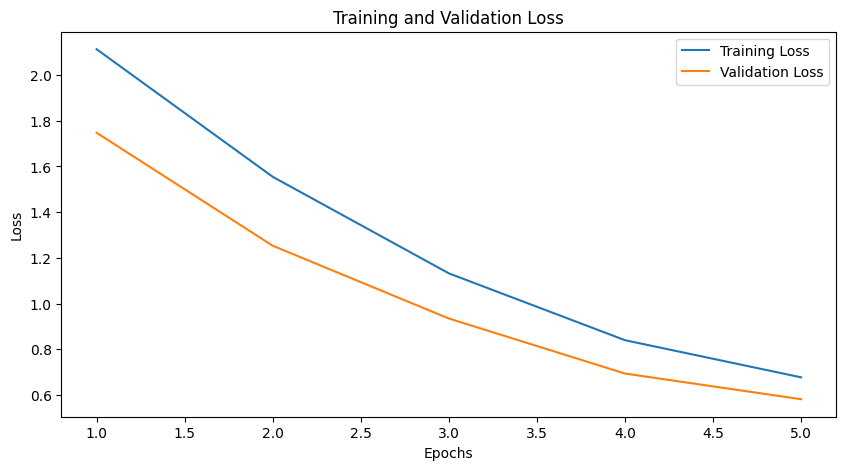

In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay = 0.00001)

import time

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Interface

In [ ]:
!pip install ipywidgets pillow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.1 MB/s eta 0:00:00


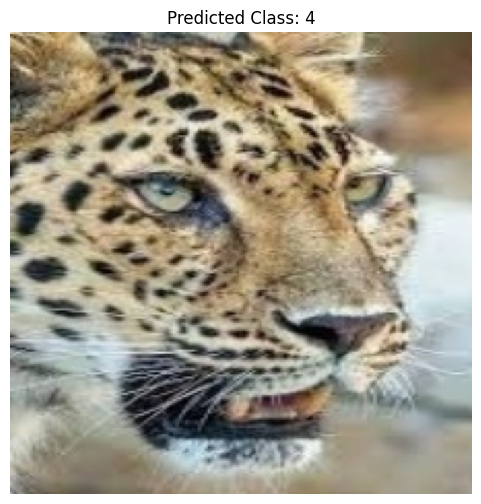

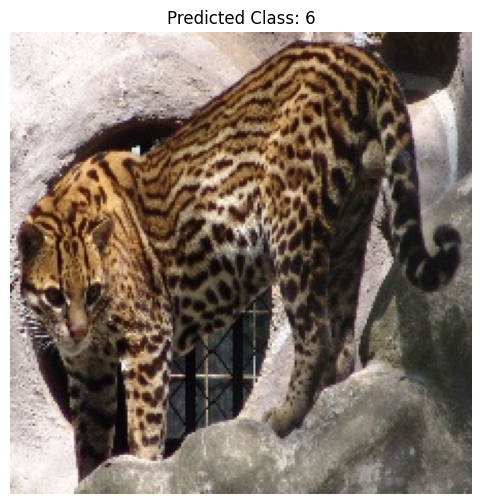

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
import os


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load('mobilenet_v2.pth', map_location=device))
model = model.to(device)
model.eval()

def preprocess_image(image_path, device):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = transform(image).unsqueeze(0).to(device)
    return image

def display_image_and_prediction(image_path):
    image = Image.open(image_path)
    input_image = preprocess_image(image_path, device)

    with torch.no_grad():
        outputs = model(input_image)
        _, predicted = torch.max(outputs, 1)

    predicted_class = predicted.item()

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

def list_image_files(directory='.'):
    supported_formats = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')
    image_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(supported_formats):
                image_files.append(os.path.join(root, file))
    return image_files

image_directory = '.'

image_files = list_image_files(image_directory)
image_dropdown = widgets.Dropdown(
    options=image_files,
    description='Select Image:',
)


predict_button = widgets.Button(description="Predict")


def on_predict_button_click(b):
    selected_file = image_dropdown.value
    if selected_file:
        display_image_and_prediction(selected_file)


predict_button.on_click(on_predict_button_click)


display(widgets.VBox([image_dropdown, predict_button]))


## Testing Phase

In [ ]:
model = vgg16(pretrained=True)

model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 93.3MB/s]


Epoch 1, Train Loss: 0.4289, Train Accuracy: 86.70%, Train Precision: 0.87, Train Recall: 0.87, Train F1: 0.87
Test Loss: 0.4907, Test Accuracy: 88.00%, Test Precision: 0.91, Test Recall: 0.88, Test F1: 0.88
Elapsed Time: 40.78 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.2563, Train Accuracy: 91.36%, Train Precision: 0.91, Train Recall: 0.91, Train F1: 0.91
Test Loss: 0.1041, Test Accuracy: 94.00%, Test Precision: 0.95, Test Recall: 0.94, Test F1: 0.94
Elapsed Time: 38.99 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.1557, Train Accuracy: 95.17%, Train Precision: 0.95, Train Recall: 0.95, Train F1: 0.95
Test Loss: 0.4733, Test Accuracy: 88.00%, Test Precision: 0.91, Test Recall: 0.88, Test F1: 0.88
Elapsed Time: 38.90 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.1114, Train Accuracy: 96.41%, Train Precision: 0.96, Train Recall: 0.96, Train F1: 0.96
Test Loss: 0.1401, Test A

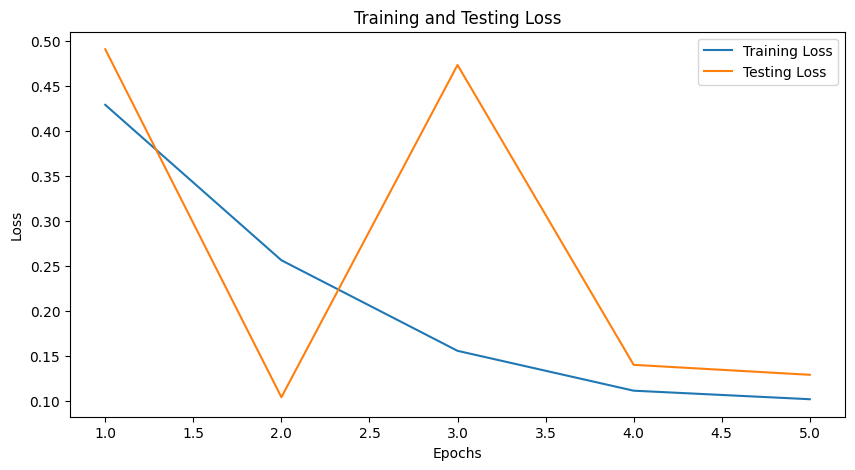

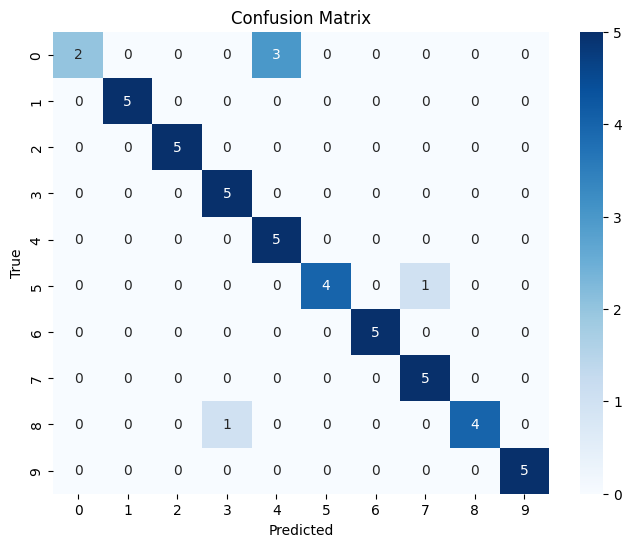

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

import time

num_epochs = 5
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    train_precision = precision_score(all_labels, all_predictions, average='macro')
    train_recall = recall_score(all_labels, all_predictions, average='macro')
    train_f1 = f1_score(all_labels, all_predictions, average='macro')

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    test_precision = precision_score(all_labels, all_predictions, average='macro')
    test_recall = recall_score(all_labels, all_predictions, average='macro')
    test_f1 = f1_score(all_labels, all_predictions, average='macro')

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train Precision: {train_precision:.2f}, Train Recall: {train_recall:.2f}, Train F1: {train_f1:.2f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Precision: {test_precision:.2f}, Test Recall: {test_recall:.2f}, Test F1: {test_f1:.2f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# Confusion Matrix for the test set
conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model = resnet18(pretrained=True)

model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)

)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


Epoch 1, Train Loss: 1.2855, Train Accuracy: 62.89%, Train Precision: 0.64, Train Recall: 0.63, Train F1: 0.63
Test Loss: 0.4423, Test Accuracy: 92.00%, Test Precision: 0.94, Test Recall: 0.92, Test F1: 0.92
Elapsed Time: 11.42 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.3522, Train Accuracy: 92.26%, Train Precision: 0.92, Train Recall: 0.92, Train F1: 0.92
Test Loss: 0.1733, Test Accuracy: 96.00%, Test Precision: 0.97, Test Recall: 0.96, Test F1: 0.96
Elapsed Time: 11.37 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.1624, Train Accuracy: 96.41%, Train Precision: 0.96, Train Recall: 0.96, Train F1: 0.96
Test Loss: 0.1344, Test Accuracy: 94.00%, Test Precision: 0.95, Test Recall: 0.94, Test F1: 0.94
Elapsed Time: 11.46 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.0877, Train Accuracy: 98.16%, Train Precision: 0.98, Train Recall: 0.98, Train F1: 0.98
Test Loss: 0.1207, Test A

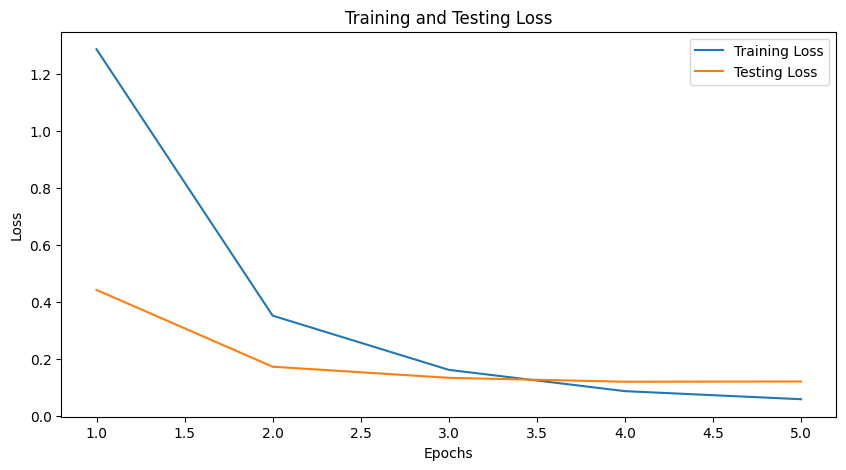

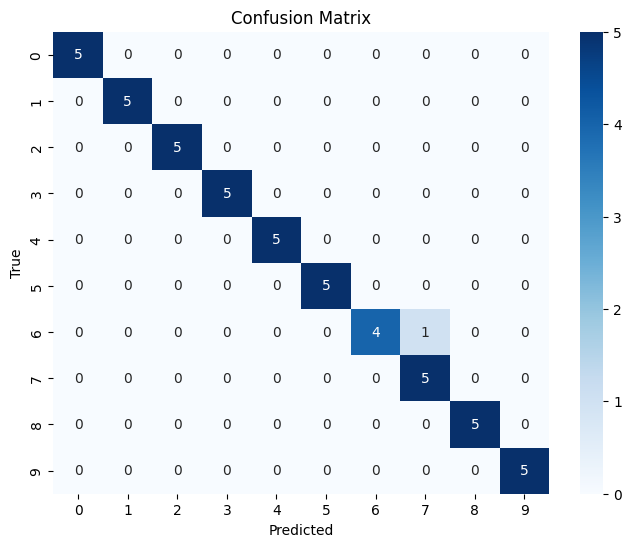

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

import time

num_epochs = 5
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_train_labels = []
    all_train_predictions = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predictions.extend(predicted.cpu().numpy())

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    train_precision = precision_score(all_train_labels, all_train_predictions, average='macro')
    train_recall = recall_score(all_train_labels, all_train_predictions, average='macro')
    train_f1 = f1_score(all_train_labels, all_train_predictions, average='macro')

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_test_labels = []
    all_test_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_test_labels.extend(labels.cpu().numpy())
            all_test_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    test_precision = precision_score(all_test_labels, all_test_predictions, average='macro')
    test_recall = recall_score(all_test_labels, all_test_predictions, average='macro')
    test_f1 = f1_score(all_test_labels, all_test_predictions, average='macro')

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train Precision: {train_precision:.2f}, Train Recall: {train_recall:.2f}, Train F1: {train_f1:.2f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Precision: {test_precision:.2f}, Test Recall: {test_recall:.2f}, Test F1: {test_f1:.2f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# Confusion Matrix for the test set
conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model = mobilenet_v2(pretrained=True)

model.classifier[1] = nn.Linear(1280, 10)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 50.5MB/s]


Epoch 1, Train Loss: 0.9618, Train Accuracy: 71.83%, Train Precision: 0.74, Train Recall: 0.72, Train F1: 0.72
Test Loss: 0.3095, Test Accuracy: 90.00%, Test Precision: 0.92, Test Recall: 0.90, Test F1: 0.90
Elapsed Time: 13.02 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.2744, Train Accuracy: 92.48%, Train Precision: 0.92, Train Recall: 0.93, Train F1: 0.92
Test Loss: 0.2146, Test Accuracy: 94.00%, Test Precision: 0.95, Test Recall: 0.94, Test F1: 0.94
Elapsed Time: 13.18 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.1509, Train Accuracy: 96.79%, Train Precision: 0.97, Train Recall: 0.97, Train F1: 0.97
Test Loss: 0.1844, Test Accuracy: 92.00%, Test Precision: 0.93, Test Recall: 0.92, Test F1: 0.92
Elapsed Time: 13.21 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.1003, Train Accuracy: 98.29%, Train Precision: 0.98, Train Recall: 0.98, Train F1: 0.98
Test Loss: 0.1667, Test A

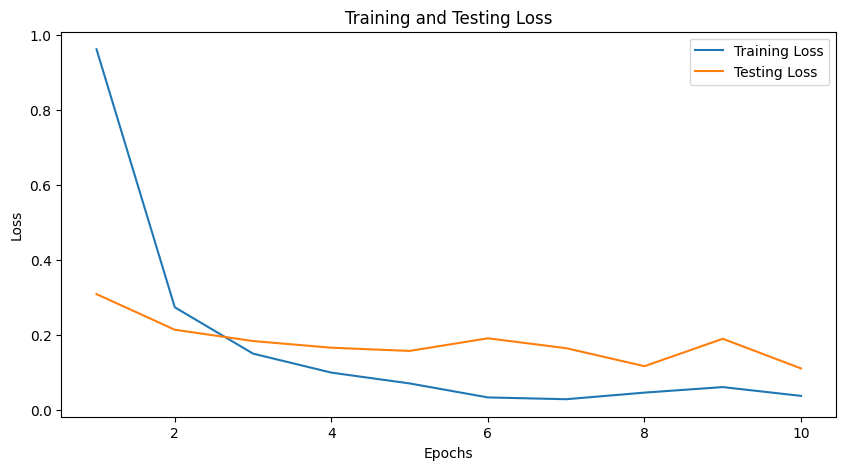

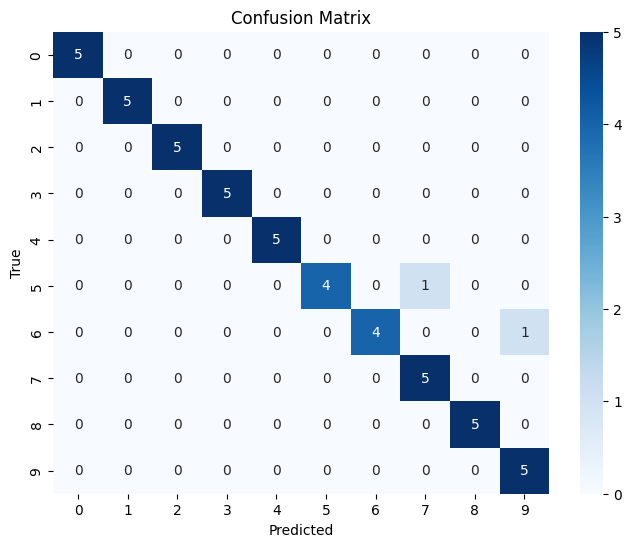

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

import time

num_epochs = 10
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_train_labels = []
    all_train_predictions = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predictions.extend(predicted.cpu().numpy())

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    train_precision = precision_score(all_train_labels, all_train_predictions, average='macro')
    train_recall = recall_score(all_train_labels, all_train_predictions, average='macro')
    train_f1 = f1_score(all_train_labels, all_train_predictions, average='macro')

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_test_labels = []
    all_test_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_test_labels.extend(labels.cpu().numpy())
            all_test_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    test_precision = precision_score(all_test_labels, all_test_predictions, average='macro')
    test_recall = recall_score(all_test_labels, all_test_predictions, average='macro')
    test_f1 = f1_score(all_test_labels, all_test_predictions, average='macro')

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train Precision: {train_precision:.2f}, Train Recall: {train_recall:.2f}, Train F1: {train_f1:.2f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Precision: {test_precision:.2f}, Test Recall: {test_recall:.2f}, Test F1: {test_f1:.2f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# Confusion Matrix for the test set
conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model = densenet121(pretrained=True)

model.classifier = nn.Sequential(
    nn.Linear(1024, 768),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.7),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 110MB/s]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Train Loss: 2.1961, Train Accuracy: 23.69%, Train Precision: 0.24, Train Recall: 0.24, Train F1: 0.21
Test Loss: 1.7654, Test Accuracy: 68.00%, Test Precision: 0.71, Test Recall: 0.68, Test F1: 0.63
Elapsed Time: 27.68 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.3219, Train Accuracy: 57.12%, Train Precision: 0.58, Train Recall: 0.57, Train F1: 0.56
Test Loss: 0.4710, Test Accuracy: 88.00%, Test Precision: 0.92, Test Recall: 0.88, Test F1: 0.87
Elapsed Time: 27.39 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.6111, Train Accuracy: 78.92%, Train Precision: 0.79, Train Recall: 0.79, Train F1: 0.79
Test Loss: 0.1463, Test Accuracy: 94.00%, Test Precision: 0.95, Test Recall: 0.94, Test F1: 0.93
Elapsed Time: 27.36 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.3637, Train Accuracy: 88.63%, Train Precision: 0.88, Train Recall: 0.89, Train F1: 0.89
Test Loss: 0.0836, Test A

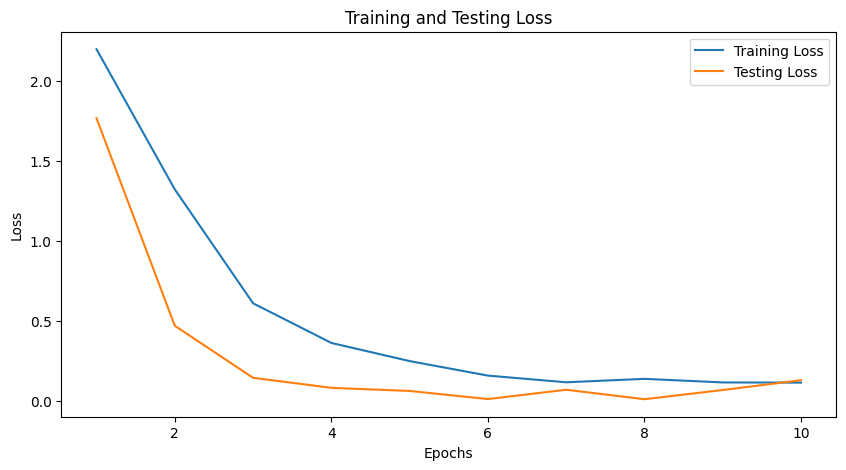

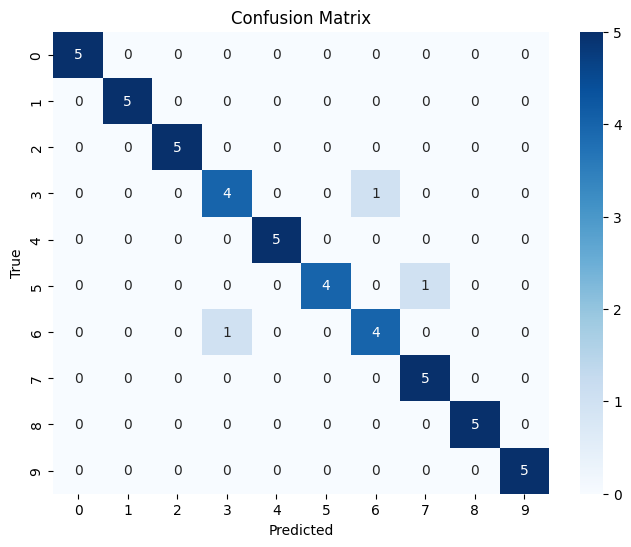

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

import time

num_epochs = 10
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_train_labels = []
    all_train_predictions = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predictions.extend(predicted.cpu().numpy())

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    train_precision = precision_score(all_train_labels, all_train_predictions, average='macro')
    train_recall = recall_score(all_train_labels, all_train_predictions, average='macro')
    train_f1 = f1_score(all_train_labels, all_train_predictions, average='macro')

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_test_labels = []
    all_test_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_test_labels.extend(labels.cpu().numpy())
            all_test_predictions.extend(predicted.cpu().numpy())

            running_loss += loss

    test_loss = running_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct / total

    test_precision = precision_score(all_test_labels, all_test_predictions, average='macro')
    test_recall = recall_score(all_test_labels, all_test_predictions, average='macro')
    test_f1 = f1_score(all_test_labels, all_test_predictions, average='macro')

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train Precision: {train_precision:.2f}, Train Recall: {train_recall:.2f}, Train F1: {train_f1:.2f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Precision: {test_precision:.2f}, Test Recall: {test_recall:.2f}, Test F1: {test_f1:.2f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# Confusion Matrix for the test set
conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
